## Sleep Quality Prediction - Supervised Machine Learning

---

by: Cody Hill

date: 1/18/2024

This project is intended for building machine learning predictive models on Oura Ring exported data. Since the data collection period is currently limited, this notebook is being built with the goal of continued data uploads (all data cleaning/analysis will be generalized for continuous new data).

### Data Source Information
All data has been exported from my personal Oura Ring on January 18, 2024 containing raw biometric data and Oura calculated data since I began wearing the device.
- Data collection starting 2/3/2023 to 1/18/2024 (last upload)
- [ Data explanations (URL to Oura?)]
### [ ADD LICENSE INFORMATION AND FAIR USE INFO ]

**TODO: oura_sleep_2024-01.csv**
- [X] Nap on day encoding
  - [X] `list(where ['type'] != long_sleep && between 10 AM - 7 PM)`
       Does the nap affect day of or next day? I chose day of
  - [X] sum(types of sleep duration)
- [ ] restless_periods vs sum(movement_30_sec) ??
- [X] Only one day per entry
  - [X] Sum each day sleep durations, restless_periods, awake_time, time_in_bed, total_sleep_duration
  - [X] `awake_time = time_in_bed - total_sleep_duration` ??
- [X] Save only the `['type'] == long_sleep, average_breath, average_heart_rate, average_hrv, latency, 
       lowest_heart_rate, betime_start_delta`
- [X] Remove: `efficiency, period, score, segment_state, sleep_midpoint, sleep_phase_5_min, movement_30_sec, timezone, 
       betime_end_delta, midpoint_at_delta, heart_rate_5_min, hrv_5_min`

**TODO: oura_daily-activity_2024-01.csv**
- [X] Remove: `average_met_minutes, equivalent_walking_distance, high_activity_met_minutes, inactivity_alerts, 
       low_activity_met_minutes, medium_activity_met_minutes, sedentary_met_minutes, target_calories, target_meters, score,
       class_5_min, met_1_min, ring_met_1_min`
- [ ] Workout daily boolean (Maybe unnecessary with other metrics compare models w/ and w/o)
- [X] Assign all activity to previous day???

**TODO: oura_daily-readiness_2024-01.csv**
- [X] Remove: `score, temperature_trend_deviation`

**TODO: oura_daily--spo2_2024-01.csv**
- [X] Deal with NaNs

**TODO: General**
- [ ] Collinearity between features checks in model selection
- [ ] Feature standardization/normalization
- [ ] Create Readme
- [ ] Print systeminfo output
- [ ] Reroute filepath to github url
- [ ] Deal with NaNs using a generalized method
- [X] Bin the Ys!
- [X] Balance train and test split classes? Note: Only works with more data, currently remove outliers (when class n < 2)
- [X] Implement regression friendly dataframe.
- [ ] ROC Curve or F1
- [ ] Previous Day's Sleep Score feature (assuming previous day sleep affects current day)
- [ ] oversampling/SMOTE 
- [ ] Different models
- [ ] Reduce Features
  - [X] Correlation matrix
  - [ ] Recursive solution: forward, backward, best subset
  - [ ] sklearn.feature_selection >> RFE

In [2630]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Setup and Data Cleaning

In [2631]:
# Import data
# TODO: Switch this to the github urls for the data so others can use.
data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data'
sleep_data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data/Sleep_Data'

# Iterate through each file in .Data/ and add it to a dataframe.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
# Using a list to concat the dfs with index_col allows to easily merge based on 'day'. More memory usage but fine for this project.
biometric_df = pd.concat([pd.read_csv(file, index_col = 'day') for file in file_path], join = 'outer', ignore_index = False, axis = 1).reset_index()

# Iterate through each file in .Data/Sleep_Data and add it to a dataframe.
# Separated sleep data as it potentially has multiple entries per day. Will merge them later.
file_path_sleep = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' not in file]
sleep_df = pd.concat(map(pd.read_csv, file_path_sleep), join = 'outer', ignore_index = False, axis = 1)

# Import ground truth label sleep score.
file_path_daily_sleep_score = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' in file]
daily_sleep_score_df = pd.read_csv(file_path_daily_sleep_score[0])
daily_sleep_score_df = daily_sleep_score_df[['score', 'day']]

In [2632]:
# First looks
print('biometric_df info:\n------------------\n', biometric_df.shape)
display(biometric_df.head(2))
print(biometric_df.columns)
print('\n\nsleep_df info:\n------------------\n', sleep_df.shape)
display(sleep_df.head(4))
print(sleep_df.columns)

biometric_df info:
------------------
 (350, 42)


,day,spo2_percentage,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,...,temperature_deviation,temperature_trend_deviation,contributors_activity_balance,contributors_hrv_balance,contributors_previous_day_activity,contributors_previous_night,contributors_recovery_index,contributors_resting_heart_rate,contributors_sleep_balance,contributors_body_temperature
0,2023-02-04,98.523,650,1.59375,10728,16,120,0,277,23220,...,-0.38,NaN,NaN,NaN,96.0,74.0,97.0,94.0,NaN,90.0
1,2023-02-05,97.181,498,1.43750,8458,8,60,0,204,15000,...,-0.04,0.15,NaN,NaN,82.0,79.0,100.0,59.0,NaN,100.0


Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'score',
       'class_5_min', 'contributors_meet_daily_targets',
       'contributors_move_every_hour', 'contributors_recovery_time',
       'contributors_stay_active', 'contributors_training_frequency',
       'contributors_training_volume', 'met_1_min', 'ring_met_1_min', 'score',
       'temperature_deviation', 'temperature_trend_deviation',
       'contributors_activity_balance', 'contributors_hrv_balance',
       'contributors_previous_day_activity', 'contributors_previous_night',
       'contributors_recov

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04T07:08:22.000-06:00,2023-02-03T22:40:22.000-06:00,2023-02-04,4650.0,85.0,990.0,...,90.0,NaN,96.0,74.0,97.0,94.0,NaN,89.0,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05T09:37:28.000-06:00,2023-02-04T23:54:28.000-06:00,2023-02-05,4590.0,82.0,180.0,...,100.0,NaN,82.0,79.0,100.0,59.0,NaN,78.0,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-05T20:10:57.000-06:00,2023-02-05T19:36:57.000-06:00,2023-02-06,30.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-05T20:36:02.000-06:00,2023-02-05T20:20:02.000-06:00,2023-02-06,0.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'score', 'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_duration', 'type', 'sleep_phase_5_min', 'timezone',
       'bedtime_start_delta', 'bedtime_end_delta', 'midpoint_at_delta',
       'heart_rate_5_min', 'hrv_5_min', 'contributors_total_sleep',
       'contributors_deep_sleep', 'contributors_rem_sleep',
       'contributors_efficiency', 'contributors_latency',
       'contributors_restfulness', 'contributors_timing',
       'readiness_contributors_activity_balance',
       'readiness_contributors_body_temperature',
       'readiness_contributors_hrv_balance',
       'readiness_contributors_previous_day_activity',
       'readiness_contributors_previous_night'

As we can see, the Oura Ring tracks and records quite a few biometrics, and with that raw biometric data they also are feature engineering and calculating new metrics to assign a daily score to categories such as sleep, recovery, readiness, activity, etc. totalling 89 features.

Since the purpose of this is to create our own sleep score predictive model, we can use Oura's sleep score as our ground truth label (y_train) in training and validation. Furthermore, we must remove the features with labels that include "contributors" as these columns contain standardized scores which Oura's models have output that are then used to average out into the final score.

*Note:* Two dataframes have been intialized here because some of the data has one entry per day (`biometric_df`), but the sleep data potentially has multiple entries per day (`sleep_df`). This was done for ease of transforming the data later.

In [2633]:
print('\n\ndaily_sleep_score_df info:\n--------------------------\n',daily_sleep_score_df.shape)
display(daily_sleep_score_df.head(4))



daily_sleep_score_df info:
--------------------------
 (336, 2)


,score,day
0,81,2023-02-04
1,81,2023-02-05
2,89,2023-02-06
3,78,2023-02-07


In [2634]:
# Remove contributor and score columns (multiple scores involved, will add truth label later).
biometric_df = biometric_df.loc[:, ~biometric_df.columns.str.contains('contributors|score')]
sleep_df = sleep_df.loc[:, ~sleep_df.columns.str.contains('contributors|score')]

print(biometric_df.shape)
print(sleep_df.shape)

(350, 26)
(685, 30)


We've removed 33 feature columns containing the word 'contributors' (or 'score' since we'll be using the score in `daily_sleep_score_df`).

Let's take a closer look at the remaining features and continue further data preparations.

In [2635]:
print(biometric_df.columns, sleep_df.columns)

Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'class_5_min',
       'met_1_min', 'ring_met_1_min', 'temperature_deviation',
       'temperature_trend_deviation'],
      dtype='object') Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_d

In [2636]:
# Confirm there are no duplicates of days in the biometric data.
biometric_df['day'].duplicated().sum()

0

We'll be removing any features that don't seem relevant to our sleep score prediction models. For now we will not touch any potentially "overlapping" features that might introduce predictor collinearity issues, but will address them later.

We'll also take a look at the remaining features' data types and see if any data munging is necessary (formatting all the features (float, int, dates, dummy/indicator encoding)).

In [2637]:
# Columns to drop
# sleep_df
drop_col_sleep = ['efficiency', 'period', 'segment_state',
            'sleep_midpoint', 'sleep_phase_5_min', 'movement_30_sec',
            'timezone', 'bedtime_end_delta', 'midpoint_at_delta',
            'heart_rate_5_min', 'hrv_5_min'] # timezone? -- might need during EDA
sleep_df.drop(drop_col_sleep, axis = 1, inplace = True)

# biometric_df
drop_col_bio = ['average_met_minutes', 'equivalent_walking_distance', 
                'high_activity_met_minutes', 'inactivity_alerts', 
                'low_activity_met_minutes', 'medium_activity_met_minutes', 
                'sedentary_met_minutes', 'target_calories', 
                'target_meters', 'class_5_min', 
                'met_1_min', 'ring_met_1_min', 
                'temperature_trend_deviation']
biometric_df.drop(drop_col_bio, axis = 1, inplace = True)

# Reformat date columns
date_col_sleep = ['bedtime_end', 'bedtime_start', 'day']
# All times reformatted to UTC
sleep_df[date_col_sleep] = sleep_df[date_col_sleep].apply(pd.to_datetime, utc = True, errors = 'coerce')
biometric_df['day'] = biometric_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')
daily_sleep_score_df['day'] = daily_sleep_score_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')

In [2638]:
# Placeholder: testing for EDA using dropped timezone column
tzone = -240
f"{int(tzone / 10 / 6)}:00"

'-4:00'

In [2639]:
print(biometric_df.dtypes)
print(sleep_df.dtypes)

day                      datetime64[ns, UTC]
spo2_percentage                      float64
active_calories                        int64
high_activity_time                     int64
low_activity_time                      int64
medium_activity_time                   int64
meters_to_target                       int64
non_wear_time                          int64
resting_time                           int64
sedentary_time                         int64
steps                                  int64
total_calories                         int64
temperature_deviation                float64
dtype: object
average_breath                                       float64
average_heart_rate                                   float64
average_hrv                                          float64
awake_time                                           float64
bedtime_end                              datetime64[ns, UTC]
bedtime_start                            datetime64[ns, UTC]
day                                

Everything above looks good, we can see that `['type']` is an object which likely means it's a string. Let's see what values it can take.

In [2640]:
sleep_df['type'].unique()

array(['long_sleep', nan, 'late_nap', 'rest', 'sleep'], dtype=object)

We can use this information along with the time data in the next section to identify different periods of sleep.

Like was mentioned before, the `sleep_df` contains multiple entries per day which either is interrupted sleep during the night or afternoon naps. Eventually we need all the data in one dataframe but first we can engineer some features with this information. 

The best solution seems to be to total all the sleep that occurred per day, accounting for sleep interruptions at night, and any naps counting towards that total as well. However, we will lose that nap information when we total the sleep times and it might also be beneficial to identify days in which naps occur, potentially increases the sleep score. We can make a new feature with this sleep info before consolidation using a binary boolean (0 = No Nap, 1 = Yes Nap). 

In [2641]:
# Initialize a time frame we can consider a nap/rest period (UTC format).
nap_upper = pd.to_datetime('23:59:00').time()
nap_lower = pd.to_datetime('14:00:00').time()
# Condition on the start, end time, and total sleep duration to filter out false-positives, remove any long_sleep types.
nap_bool = ((sleep_df['bedtime_start'].dt.time >= nap_lower) & 
            (sleep_df['bedtime_end'].dt.time <= nap_upper) & 
            (sleep_df['total_sleep_duration'] > 600) &
            (sleep_df['type'] != 'long_sleep'))
print('Naps identified:\n')
display(sleep_df[nap_bool])
# Insert a nap_today column and binary yes/no for each day.
# Initialize column with zeroes.
sleep_df['nap_today'] = np.zeros_like(sleep_df.shape[0])
# Use boolean array to identify nap days and iterate through to change nap_today to 1.
# TODO: This is not the pandas way but fine with this amount of data. Use a better method later.
# Something like, sleep_df['nap_today'].where(~nap_bool, 1, inplace = True) does not work in this situation..
# Need each entry for that day to = 1 not just the nap itself.
nap_days = sleep_df[nap_bool]['day']
for day in nap_days:
    sleep_df.loc[sleep_df['day'] == day, 'nap_today'] = 1

Naps identified:



,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN
44,14.750,90.50,25.0,3690.0,2023-02-27 01:11:23+00:00,2023-02-26 23:54:23+00:00,2023-02-27 00:00:00+00:00,300.0,2760.0,540.0,90.0,90.0,24.0,4620,930.0,NaN,60863,NaN,NaN
53,14.750,NaN,NaN,1140.0,2023-03-01 23:27:00+00:00,2023-03-01 22:51:00+00:00,2023-03-01 00:00:00+00:00,570.0,750.0,420.0,NaN,30.0,11.0,2160,1020.0,NaN,60660,NaN,NaN
63,14.625,71.67,NaN,930.0,2023-03-06 22:03:32+00:00,2023-03-06 21:30:32+00:00,2023-03-06 00:00:00+00:00,630.0,390.0,420.0,70.0,0.0,31.0,1980,1050.0,NaN,55832,NaN,NaN
88,13.750,65.15,75.0,1530.0,2023-03-17 21:33:33+00:00,2023-03-17 20:17:33+00:00,2023-03-17 00:00:00+00:00,90.0,450.0,2940.0,62.0,0.0,88.0,4560,3030.0,NaN,55053,NaN,NaN
89,13.750,68.33,63.0,2070.0,2023-03-17 23:52:33+00:00,2023-03-17 22:48:33+00:00,2023-03-18 00:00:00+00:00,540.0,1410.0,780.0,63.0,450.0,12.0,3840,1770.0,late_nap,64113,NaN,NaN
116,13.625,70.40,70.0,3030.0,2023-03-30 20:27:01+00:00,2023-03-30 19:26:01+00:00,2023-03-30 00:00:00+00:00,180.0,690.0,450.0,68.0,0.0,10.0,3660,630.0,NaN,51961,NaN,NaN
152,14.125,61.20,107.0,750.0,2023-04-23 21:10:49+00:00,2023-04-23 20:29:49+00:00,2023-04-23 00:00:00+00:00,1260.0,330.0,450.0,56.0,0.0,15.0,2460,1710.0,sleep,55789,NaN,NaN
180,14.875,71.20,80.0,1080.0,2023-05-10 18:45:42+00:00,2023-05-10 17:44:42+00:00,2023-05-10 00:00:00+00:00,810.0,570.0,1770.0,67.0,0.0,29.0,3660,2580.0,sleep,45882,NaN,NaN


Continuing to setup our feature dataframe, the day in which the biometric data is being collected will affect the next day. Currently, and maybe obviously, the sleep score is recorded on the day you wake on, meaning each date is referencing the previous night's sleep. This is important to note because the features we're left with in the `biometric_df` is being collected on the day in which a sleep score has already been recorded (e.g., calories burned, steps, heart rate, etc). Logically this data is more relevant to the upcoming night's sleep, therefore, we need to shift this date 1 day to align with our model's target/response variable (sleep score).

In [2642]:
biometric_df['day'] = biometric_df['day'] + pd.DateOffset(days = 1)
display(biometric_df)
sleep_min_idx = sleep_df.loc[sleep_df['day'] == sleep_df['day'].min()].index
bio_min_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].min()].index
bio_max_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].max()].index

#biometric_df.drop(index = bio_min_idx, axis = 0, inplace = True)
biometric_df.drop(index = bio_max_idx, axis = 0, inplace = True)
# sleep_df.drop(sleep_min_idx, axis = 0, inplace = True)

# biometric_df.reset_index(drop = True, inplace = True)
# sleep_df.reset_index(drop = True, inplace = True)

print(biometric_df['day'].min())
print(sleep_df['day'].min())
print(biometric_df['day'].max())
print(sleep_df['day'].max())

biometric_df.loc[biometric_df['day'] == '2023-02-04 00:00:00+00:00']

,day,spo2_percentage,active_calories,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,2023-02-05 00:00:00+00:00,98.523,650,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
1,2023-02-06 00:00:00+00:00,97.181,498,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
2,2023-02-07 00:00:00+00:00,99.177,400,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
3,2023-02-08 00:00:00+00:00,98.634,523,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
4,2023-02-10 00:00:00+00:00,98.440,530,60,13440,3780,-400,1200,35040,32880,8728,2876,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2023-09-22 00:00:00+00:00,NaN,899,180,26760,5400,-6800,3000,30000,21060,18552,3292,NaN
346,2023-10-17 00:00:00+00:00,NaN,472,60,13680,2760,500,0,33960,35940,8701,2761,-0.20
347,2023-11-06 00:00:00+00:00,NaN,563,120,16920,2580,-1000,19200,21660,25920,9925,2906,NaN
348,2023-11-30 00:00:00+00:00,NaN,97,0,3180,480,7100,0,49260,33480,1601,2229,NaN


2023-02-04 00:00:00+00:00
2023-02-04 00:00:00+00:00
2024-01-18 00:00:00+00:00
2024-01-18 00:00:00+00:00


,day,spo2_percentage,active_calories,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
329,2023-02-04 00:00:00+00:00,NaN,140,0,8460,120,6300,36000,19680,22140,2718,2429,NaN


In [2643]:
sleep_df_long = sleep_df.loc[sleep_df['type'] == 'long_sleep']

# Use merge() to find the differences in dataframes indicating days that didn't record a long sleep.
# Requires a method where the two df indexes don't match.
# Method credit to: https://stackoverflow.com/questions/48647534/find-difference-between-two-data-frames
no_sleep = pd.DataFrame(sleep_df['day']).merge(sleep_df_long['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']
display(no_sleep)

# We can remove these days from the main dataframes as they won't have scores anyways.
# Sleep DF
sleep_df.drop(no_sleep.index, axis = 0, inplace = True)

# Biometric DF
# We can use our previous work and just remove the days that the two DFs don't share.
no_sleep_bio_days =  pd.DataFrame(biometric_df['day']).merge(sleep_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day']
no_sleep_bio_index = biometric_df[biometric_df['day'].isin(no_sleep_bio_days)].index

biometric_df.drop(no_sleep_bio_index, axis = 0, inplace = True)

# Daily Sleep Score DF
no_sleep_score_index = pd.DataFrame(daily_sleep_score_df['day']).merge(biometric_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day'].index
daily_sleep_score_df.drop(index = no_sleep_score_index, axis = 0, inplace = True)
# Instead of having 0-100 potential label predictions we should bin them.
# Create bins. We can use .5 to avoid having to decide left or right edge issues.
bins = np.linspace(0.5, 100.5, 21, dtype = float)
bin_labels = [f"{i} to {i + 5}" for i in bins if i != bins[-1]]
# np.digitize() can map the scores to the correct bins
bin_idx = np.digitize(daily_sleep_score_df['score'], bins, right = False)
# Create new column with the new bin labels
daily_sleep_score_df['score_bin'] = [bin_labels[value - 1] for value in bin_idx]
display(daily_sleep_score_df.head(5))
# We can now remove the day column from the daily_sleep_score_df
#daily_sleep_score_df.drop(daily_sleep_score_df.loc[daily_sleep_score_df['day'] == daily_sleep_score_df['day'].min()].index, axis = 0, inplace = True)
print(daily_sleep_score_df['day'].min())
print(daily_sleep_score_df['day'].max())
daily_sleep_score_df.drop(['day'], axis = 1, inplace = True)

,day,_merge
103,2023-03-24 00:00:00+00:00,left_only
140,2023-04-15 00:00:00+00:00,left_only
161,2023-05-01 00:00:00+00:00,left_only
162,2023-05-01 00:00:00+00:00,left_only
163,2023-05-02 00:00:00+00:00,left_only
173,2023-05-08 00:00:00+00:00,left_only
223,2023-05-28 00:00:00+00:00,left_only
224,2023-05-28 00:00:00+00:00,left_only
326,2023-07-24 00:00:00+00:00,left_only
402,2023-08-31 00:00:00+00:00,left_only


,score,day,score_bin
0,81,2023-02-04 00:00:00+00:00,80.5 to 85.5
1,81,2023-02-05 00:00:00+00:00,80.5 to 85.5
2,89,2023-02-06 00:00:00+00:00,85.5 to 90.5
3,78,2023-02-07 00:00:00+00:00,75.5 to 80.5
4,80,2023-02-08 00:00:00+00:00,75.5 to 80.5


2023-02-04 00:00:00+00:00
2024-01-18 00:00:00+00:00


In [2644]:
# Sum each day's sleep metrics (for days with interrupted sleep or naps).
sleep_df = sleep_df[['day', 
         'deep_sleep_duration', 
         'light_sleep_duration', 
         'rem_sleep_duration', 
         'restless_periods', 
         'awake_time', 
         'time_in_bed', 
         'total_sleep_duration']].groupby(['day']).sum().reset_index()

In [2645]:
# Features extracted only from the long sleep to include in the final dateframe.
sleep_df_long = sleep_df_long[['day', 
                               'average_breath', 
                               'average_heart_rate', 
                               'average_hrv', 
                               'latency', 
                               'lowest_heart_rate', 
                               'bedtime_start_delta',
                               'nap_today']]

In [2646]:
sleep_df = sleep_df.merge(sleep_df_long, on = 'day', how = 'outer')
sleep_df.head(2)

,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,latency,lowest_heart_rate,bedtime_start_delta,nap_today
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,990.0,56.0,-4778,0
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,180.0,75.0,-332,0


In [2647]:
sleep_df.shape

(334, 15)

In [2648]:
biometric_df.shape

(334, 13)

In [2649]:
daily_sleep_score_df.shape

(334, 2)

In [2650]:
bio_sleep_df = sleep_df.merge(biometric_df, on = 'day', how = 'outer')
bio_sleep_df.drop(['day'], axis = 1, inplace = True)
display(bio_sleep_df)
bio_sleep_df.iloc[287]

,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,...,0,8460,120,6300,36000,19680,22140,2718,2429,NaN
1,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,59.0,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,54.0,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,49.0,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,67.0,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
330,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,67.0,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
331,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,106.0,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
332,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,140.0,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


deep_sleep_duration       4080.000
light_sleep_duration     16110.000
rem_sleep_duration        3390.000
restless_periods           223.000
awake_time               27456.000
time_in_bed              51036.000
total_sleep_duration     23580.000
average_breath              14.250
average_heart_rate          81.180
average_hrv                 33.000
latency                   1380.000
lowest_heart_rate           67.000
bedtime_start_delta       2671.000
nap_today                    1.000
spo2_percentage             98.626
active_calories            532.000
high_activity_time          60.000
low_activity_time        16560.000
medium_activity_time      2760.000
meters_to_target         -3000.000
non_wear_time              180.000
resting_time             21180.000
sedentary_time           45660.000
steps                     9435.000
total_calories            2957.000
temperature_deviation        0.120
Name: 287, dtype: float64

In [2651]:
bio_sleep_df.columns

Index(['deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration',
       'restless_periods', 'awake_time', 'time_in_bed', 'total_sleep_duration',
       'average_breath', 'average_heart_rate', 'average_hrv', 'latency',
       'lowest_heart_rate', 'bedtime_start_delta', 'nap_today',
       'spo2_percentage', 'active_calories', 'high_activity_time',
       'low_activity_time', 'medium_activity_time', 'meters_to_target',
       'non_wear_time', 'resting_time', 'sedentary_time', 'steps',
       'total_calories', 'temperature_deviation'],
      dtype='object')

In [2652]:
# Explore and deal with NaN values.
# A good option to deal with each feature individually.
# >>> values = {{"A": 0, "B": 1, "C": 2, "D": 3}}
# >>> df.fillna(value=values)
# Only feature with NaN currently is SPO2, median for now.
# TODO: Come back and tune each feature.
display(bio_sleep_df.isna().any())
bio_sleep_df.fillna(bio_sleep_df.median(), inplace = True)

deep_sleep_duration      False
light_sleep_duration     False
rem_sleep_duration       False
restless_periods         False
awake_time               False
time_in_bed              False
total_sleep_duration     False
average_breath           False
average_heart_rate       False
average_hrv              False
latency                  False
lowest_heart_rate        False
bedtime_start_delta      False
nap_today                False
spo2_percentage           True
active_calories          False
high_activity_time       False
low_activity_time        False
medium_activity_time     False
meters_to_target         False
non_wear_time            False
resting_time             False
sedentary_time           False
steps                    False
total_calories           False
temperature_deviation     True
dtype: bool

### Exploratory Data Analysis (EDA)

In [2653]:
daily_sleep_score_df.describe()

,score
count,334.000000
mean,75.688623
std,8.384459
min,36.000000
25%,71.000000
50%,77.000000
75%,81.000000
max,94.000000


<Axes: >

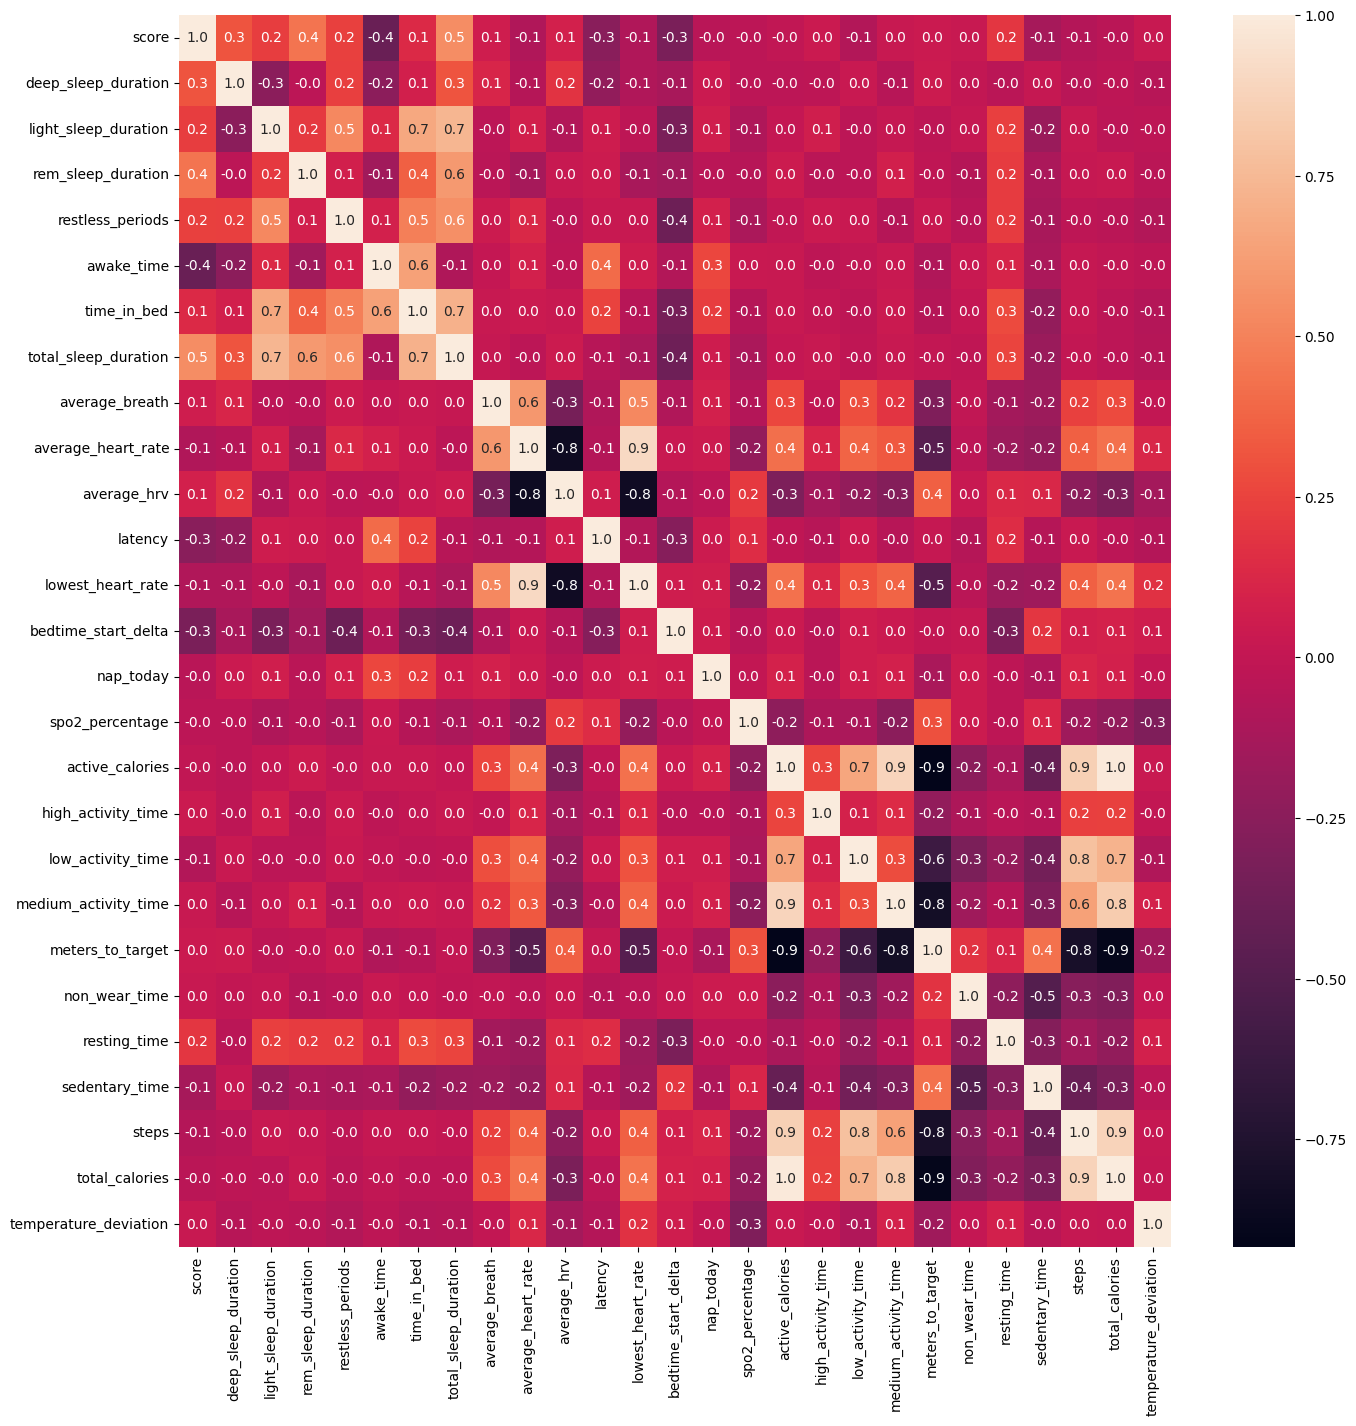

In [2654]:
# Correlation
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
fig, ax = plt.subplots(figsize = (16, 16))
# Include score column to see correlation between response and predictors too.
sns.heatmap(corr_matrix, ax = ax, annot = True,  fmt = '.1f')

In [2655]:
corr_matrix_abs = corr_matrix.abs()

corr_matrix_abs.drop('score', axis = 0, inplace = True)
corr_matrix_abs.drop('score', axis = 1, inplace = True)

upper_tri = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))
# threshold greater than 0.75
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop)

['average_hrv', 'lowest_heart_rate', 'medium_activity_time', 'meters_to_target', 'steps', 'total_calories']


#### Standardize Features
Since we'll be using many machine learning models in which regularization techniques are sensitive to differences in predictor variance magnitudes/scale (e.g., Lasso/Ridge Regression, SVM, etc.) and expect features to be roughly normally distributed, we will be standardizing the features appropriately.

### Helper Functions

In [2656]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['max_depth']), len(grid.param_grid['max_leaf_nodes']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('max_depth')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['max_leaf_nodes'])), grid.param_grid['max_leaf_nodes'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['max_depth'])), grid.param_grid['max_depth'])
    plt.title('Validation accuracy')
    plt.show()

def plotSearchGridSVM(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['C']), len(grid.param_grid['gamma']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['gamma'])), grid.param_grid['gamma'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['C'])), grid.param_grid['C'])
    plt.title('Validation accuracy')
    plt.show()

### Model Selection

#### Train Test Split

---



In [2657]:
display(daily_sleep_score_df['score_bin'].value_counts())
# Remove outlier for now so we can class-balance the splits (min per class required = 2)
# TODO: Remove hardcoded solution, get counts and delete if == 1 in case of new data.
#       (Maybe use daily_sleep_score_df['score_bin'].value_counts() == 1)
class_outlier_loc = daily_sleep_score_df.loc[daily_sleep_score_df['score_bin'] == '35.5 to 40.5']
print(class_outlier_loc)
daily_sleep_score_df.drop(class_outlier_loc.index, axis = 0, inplace = True)
bio_sleep_df.drop(class_outlier_loc.index, axis = 0, inplace = True)

score_bin
75.5 to 80.5    86
80.5 to 85.5    72
70.5 to 75.5    69
65.5 to 70.5    41
85.5 to 90.5    26
60.5 to 65.5    24
55.5 to 60.5     7
90.5 to 95.5     3
45.5 to 50.5     3
40.5 to 45.5     2
35.5 to 40.5     1
Name: count, dtype: int64

     score     score_bin
287     36  35.5 to 40.5


In [2658]:
rand_state = 98784 # Used in all classifiers
# Binned/Categorical Class Labels
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(bio_sleep_df, daily_sleep_score_df['score_bin'], 
                                                    test_size = 0.2, 
                                                    random_state = rand_state, 
                                                    stratify = daily_sleep_score_df['score_bin'])
# Discretized Scores
# Can't stratify-balance the classes with this low amount of data
X_train, X_test, y_train, y_test = train_test_split(bio_sleep_df, daily_sleep_score_df['score'], 
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

#### Linear Regression / Logistic Classification

In [2659]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# import scipy as sp
# import scipy.stats as stats
import statsmodels.formula.api as smf

clf_log_regression = LogisticRegression(solver = 'sag', max_iter = 10000, random_state = rand_state).fit(X_train_bin, y_train_bin)
print(clf_log_regression.score(X_test_bin, y_test_bin))

clf_lin_regression = LinearRegression(random_state = rand_state).fit(X_train, y_train)
print(clf_lin_regression.score(X_test, y_test))
feat_coef = list(zip(clf_lin_regression.coef_, clf_lin_regression.feature_names_in_))
print(feat_coef)

clf_ridge_regression = Ridge(max_iter = 10000, random_state = rand_state).fit(X_train, y_train)
print(clf_ridge_regression.score(X_test, y_test))

clf_lasso_regression = Lasso(max_iter = 10000, random_state = rand_state).fit(X_train, y_train)
print(clf_lasso_regression.score(X_test, y_test))

0.5522388059701493


TypeError: LinearRegression.__init__() got an unexpected keyword argument 'random_state'

In [ ]:
bio_sleep_df.reset_index(drop = True, inplace = True)
daily_sleep_score_df.reset_index(drop = True, inplace = True)

ols_format_df = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1)

In [ ]:
ols_format_df

,score,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,81,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,...,0,8460,120,6300,36000,19680,22140,2718,2429,0.02
1,81,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,89,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,78,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,80,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,77,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
329,85,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
330,64,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
331,77,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


In [ ]:
ols_predictors

['deep_sleep_duration',
 'light_sleep_duration',
 'rem_sleep_duration',
 'restless_periods',
 'awake_time']

In [ ]:
# Remove first column (score)
ols_predictors = (ols_format_df.columns[1:2]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score ~ {ols_pred_string[3:]}', data = ols_format_df).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     68.19
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.59e-15
Time:                        17:11:15   Log-Likelihood:                -1137.8
No. Observations:                 333   AIC:                             2280.
Df Residuals:                     331   BIC:                             2287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              65.1774      1.350     48.295      0.000      62.523      67.832
deep_sleep_duration     0.0020      0.000      8.258      0.000       0.002       0.002
==============================================================================
Omnibus:                       32.273   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.483
Skew:                          -0.717   Prob(JB):                     9.82e-10
Kurtosis:                       3.967   Cond. No.                     1.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Support Vector Machine (SVM)

In [ ]:
params = {'C': np.logspace(-5, 5, base = 2), 'gamma': np.logspace(-5, 5, base = 2)}
grid_svm = GridSearchCV(SVC(kernel = 'rbf'), param_grid = params, cv = 3).fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


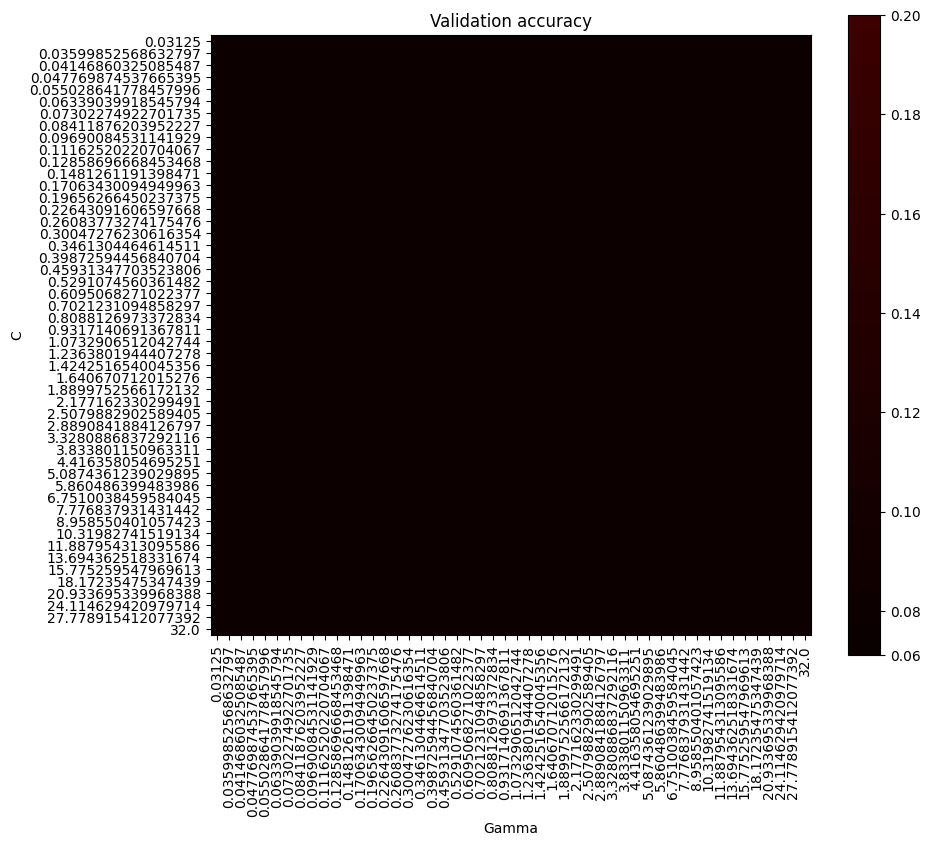

In [ ]:
plotSearchGridSVM(grid_svm)

GridSearch results indicate the optimized parameters are, 
C: 0.03125, Gamma: 0.03125, Accuracy: 0.07894960844399046
0.5522388059701493


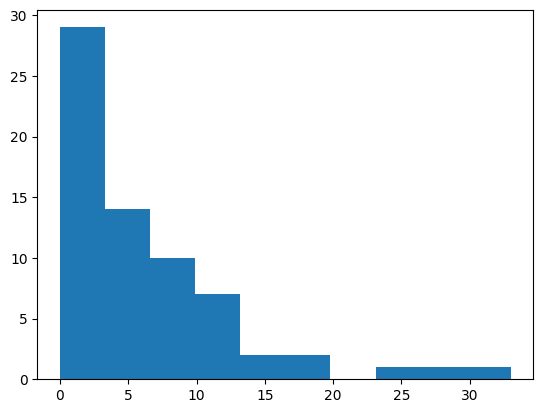

In [ ]:
scores = [x for x in grid_svm.cv_results_["mean_test_score"]]

max_index = scores.index(max(scores))
max_score = max(scores)
opt_C = grid_svm.cv_results_['param_C'][max_index]
opt_Gamma = grid_svm.cv_results_['param_gamma'][max_index]

print(f'GridSearch results indicate the optimized parameters are, \nC: {opt_C}, Gamma: {opt_Gamma}, Accuracy: {max_score}')

# OR use the attribute .best_params_
grid_svm.best_params_

results_svm = list(zip(grid_svm.predict(X_test), y_test))
pred_delta_svm = [abs(pred - truth) for pred, truth in results_svm]
plt.hist(pred_delta_svm)
print((np.array(pred_delta_svm) <= 5).sum() / len(pred_delta_svm))

#### Decision Trees

In [ ]:
dt = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = None, random_state = rand_state).fit(X_train, y_train)
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))
#path = dt.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities

1.0
0.11940298507462686


##### AdaBoost

---



In [ ]:
adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                   n_estimators = 100,
                   random_state = None,
                   learning_rate = 0.5
                   ).fit(X_train, y_train)
print(adaboost_clf.score(X_test, y_test))
# results_adaboost = list(zip(adaboost_clf.predict(X_test), y_test))
# pred_delta_adaboost = [abs(pred - truth) for pred, truth in results_adaboost]
# plt.hist(pred_delta_adaboost)
# print((np.array(pred_delta_adaboost) <= 5).sum() / len(pred_delta_adaboost))

0.07462686567164178


##### Random Forest

---


In [ ]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid = GridSearchCV(RandomForestClassifier(random_state=rand_state), param_grid = params, cv = 3, verbose = 3, n_jobs = -1).fit(X_train, y_train)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.079 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.079 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.079 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.114 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.114 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.079 total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 1/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.114 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.114 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.114 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=30;, score=0.079 total time=   0.0s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=26;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=34;, score=0.079 total time=   0.0s
[CV 2/3] END ....max_depth=1

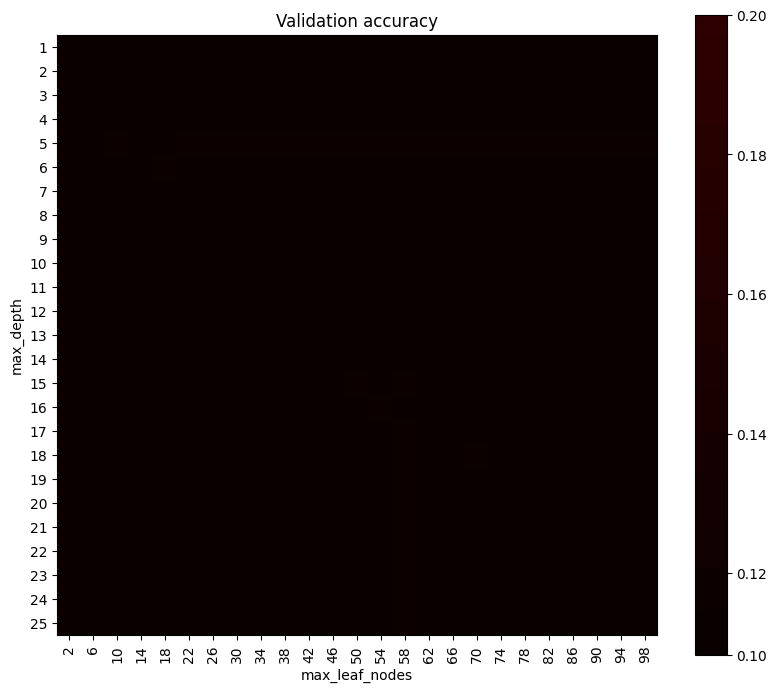

In [ ]:
plotSearchGrid(grid)

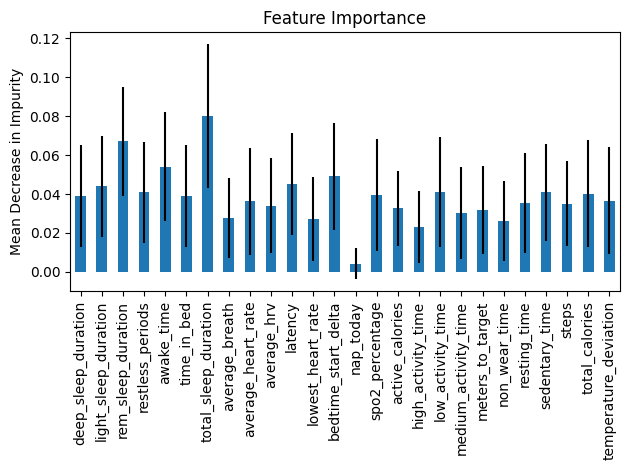

In [ ]:
feat_importance = grid.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

In [ ]:
grid.best_estimator_

RandomForestClassifier(max_depth=15, max_leaf_nodes=58, random_state=98784)

0.11940298507462686


ValueError: The number of FixedLocator locations (30), usually from a call to set_ticks, does not match the number of labels (29).

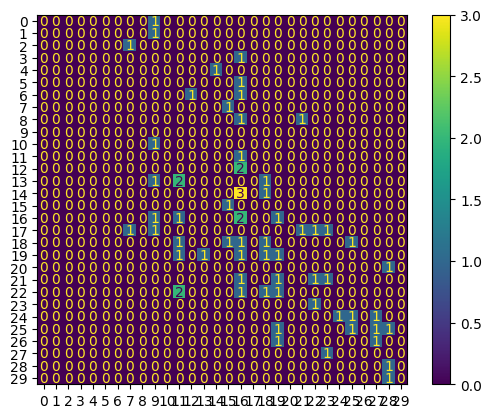

In [ ]:
print(grid.best_estimator_.score(X_test, y_test))

cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted(y_test.unique()))
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
results_bins = (grid.best_estimator_.predict(X_test))
results_bins[0]

'75.5 to 80.5'

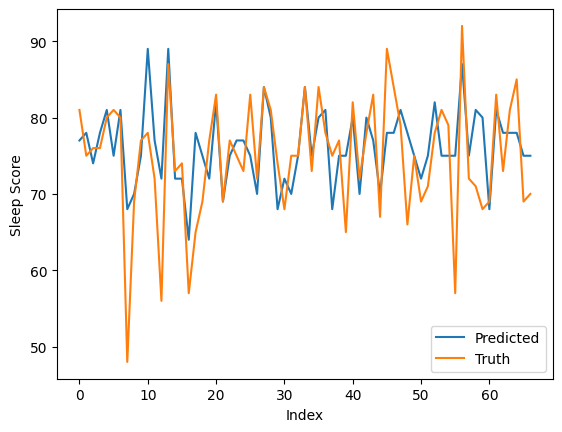

In [ ]:
results_randforrest = list(zip(grid.best_estimator_.predict(X_test), y_test))
plt.plot(results_randforrest, label = ['Predicted', 'Truth'])
plt.xlabel('Index')
plt.ylabel('Sleep Score')
plt.plot()
plt.legend()

0.6865671641791045

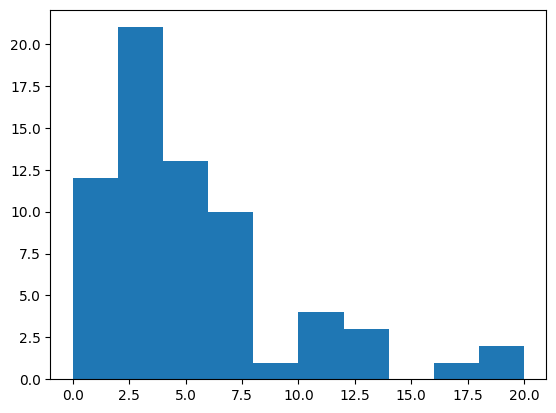

In [ ]:
pred_delta_randforrest = [abs(pred - truth) for pred, truth in results_randforrest]
plt.hist(pred_delta_randforrest)
(np.array(pred_delta_randforrest) <= 5).sum() / len(pred_delta_randforrest)